# Data Description
In this dataset, you are provided with a large number of small pathology images to classify. Files are named with an image id. The train_labels.csv file provides the ground truth for the images in the train folder. You are predicting the labels for the images in the test folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. We have otherwise maintained the same data and splits as the PCam benchmark.

## I will cover the following recipes:
* Exploring the dataset
* Creating a custom dataset
* Splitting the dataset
* Transforming the data
* Creating dataloaders
* Building the classification model
* Defining the loss function
* Defining the optimizer
* Training and evaluation of the model
* Deploying the model
* Model inference on test data

# Exploring the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as plt
from PIL import Image, ImageDraw
import numpy as np
import os

In [2]:
path2csv ='../input/histopathologic-cancer-detection/train_labels.csv'
labels_df = pd.read_csv(path2csv)
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [3]:
labels_df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

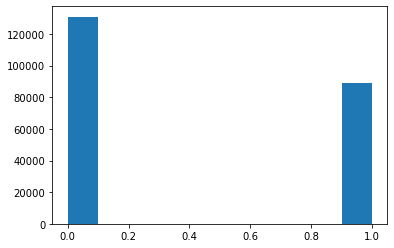

In [4]:
%matplotlib inline
plt.hist(labels_df['label'])
plt.show()

**let's visualize a few images that have a positive label. A positive label shows that
the center 32 x 32 region of an image contains at least one pixel of tumor tissue**

In [5]:
# get the ids for malignant images
malignantIds = labels_df.loc[labels_df['label']==1]['id'].values

In [6]:
malignantIds

array(['c18f2d887b7ae4f6742ee445113fa1aef383ed77',
       'a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da',
       '7f6ccae485af121e0b6ee733022e226ee6b0c65f', ...,
       '309210db7f424edbc22b2d13bf2fa27518b18f5c',
       'd4b854fe38b07fe2831ad73892b3cec877689576',
       'a81f84895ddcd522302ddf34be02eb1b3e5af1cb'], dtype=object)

In [7]:
# Define the path to data:
path2train = '../input/histopathologic-cancer-detection/train'

In [8]:
# show images in grayscale, if you want color change it to True
color=False

In [9]:
# e set the figure sizes:
plt.rcParams['figure.figsize'] = (10.0,10.0)
plt.subplots_adjust(wspace=0, hspace=0)
nrows,ncols=3,3

<Figure size 720x720 with 0 Axes>

### display the images

c18f2d887b7ae4f6742ee445113fa1aef383ed77
a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da
7f6ccae485af121e0b6ee733022e226ee6b0c65f
c3d660212bf2a11c994e0eadff13770a9927b731
94fa32b29cc1c00403176c0795fffa3cfaa0f20e
0b820b71670c039dd0a51333d1c919f471a9e940
d34af1e7500f2f3de41b0e6fdeb2ed245d814590
464327050ef07bb927f8bfb5c4e4dd5ebd4d3c09
6961bdcc16f6c1d7db88fc6a7823178288c2a29e


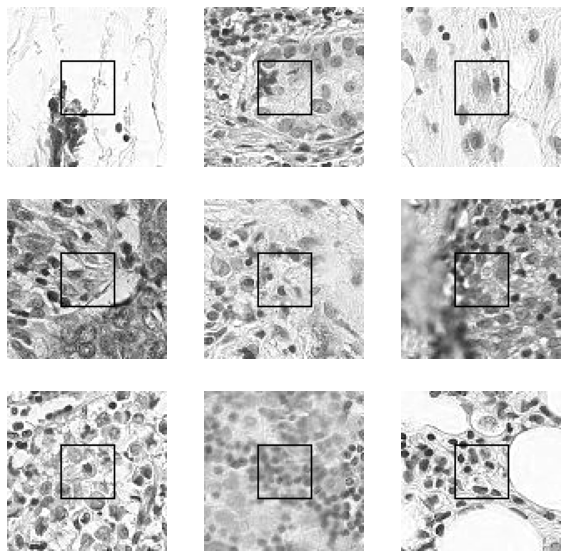

In [10]:
for i,id_ in enumerate(malignantIds[:nrows*ncols]):
    print(id_)
    full_filenames = os.path.join(path2train , id_ +'.tif')
    # load image
    img = Image.open(full_filenames)
    # draw a 32*32 rectangle
    draw = ImageDraw.Draw(img)
    draw.rectangle(((32, 32), (64, 64)),outline="green")
    plt.subplot(3, 3, i+1)
    if color is True:
        plt.imshow(np.array(img))
    else:
        plt.imshow(np.array(img)[:,:,0],cmap="gray")
    plt.axis('off')

In [11]:
#See what the path looks like
full_filenames

'../input/histopathologic-cancer-detection/train/6961bdcc16f6c1d7db88fc6a7823178288c2a29e.tif'

In [12]:
labels_df.loc[labels_df['label']==0]['id'].values

array(['f38a6374c348f90b587e046aac6079959adf3835',
       '755db6279dae599ebb4d39a9123cce439965282d',
       'bc3f0c64fb968ff4a8bd33af6971ecae77c75e08', ...,
       '53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6',
       '3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75',
       'f129691c13433f66e1e0671ff1fe80944816f5a2'], dtype=object)

# Creating a custom dataset
create a custom Dataset class by subclassing the PyTorch Dataset class.

In [13]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import torchvision.transforms as transforms


In [14]:
# fix torch random seed
torch.manual_seed(0)

In [15]:
class histoCancerDataset(Dataset):
    def __init__(self, data_dir, transform,data_type="train"):
    
        # path to images
        path2data=os.path.join(data_dir,data_type)

        # get list of images
        filenames = os.listdir(path2data)

        # get the full path to images
        self.full_filenames = [os.path.join(path2data, f) for f in filenames]

        # labels are in a csv file named train_labels.csv
        path2csvLabels=os.path.join(data_dir,"train_labels.csv")
        labels_df=pd.read_csv(path2csvLabels)

        # set data frame index to id
        labels_df.set_index("id", inplace=True)

        # obtain labels from data frame
        self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]

        self.transform = transform
        
    def __len__(self):
        #return the size of dataset
        return len(self.full_filenames)
    
    def __getitem__(self, idx):
        # open image, apply transforms and return with label
        image = Image.open(self.full_filenames[idx])  
        image = self.transform(image)
        return image, self.labels[idx]

In [16]:
import torchvision.transforms as transforms
data_transformer = transforms.Compose([transforms.ToTensor()])

In [17]:
data_dir = "../input/histopathologic-cancer-detection"
histo_dataset = histoCancerDataset(data_dir, data_transformer, "train")
print(len(histo_dataset))

220025


In [18]:
# load an image
img,label=histo_dataset[9]
print(img.shape,torch.min(img),torch.max(img))

torch.Size([3, 96, 96]) tensor(0.0667) tensor(1.)


# Splitting the dataset

**We need to provide a validation dataset to track the model's performance during training.
We use 20% of histo_dataset as the validation dataset and use the rest as the training
dataset.**

### Let's split histo_dataset:

In [19]:
from torch.utils.data import random_split

len_histo=len(histo_dataset)
len_train=int(0.8*len_histo)
len_val=len_histo-len_train

train_ds,val_ds=random_split(histo_dataset,[len_train,len_val])

print("train dataset length:", len(train_ds))
print("validation dataset length:", len(val_ds))


train dataset length: 176020
validation dataset length: 44005


In [20]:
#get an image from the training dataset:
for x,y in train_ds:
    print(x.shape,y)
    break

torch.Size([3, 96, 96]) 1


In [21]:
# get an image from the validation dataset:
for x,y in val_ds:
    print(x.shape,y)
    break

torch.Size([3, 96, 96]) 0


### Let's display a few samples from train_ds

In [22]:
import torch.utils
import numpy as np 
np.random.seed(0)

#### Define a helper function to show an image:

image indices: [ 43567 173685 117952 152315]
torch.Size([3, 100, 394])


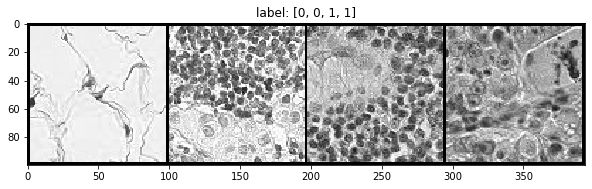

In [23]:
from torchvision import utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)


def show(img,y,color=False):
    # convert tensor to numpy array
    npimg = img.numpy()
   
    # Convert to H*W*C shape
    npimg_tr=np.transpose(npimg, (1,2,0))
    
    if color==False:
        npimg_tr=npimg_tr[:,:,0]
        plt.imshow(npimg_tr,interpolation='nearest',cmap="gray")
    else:
        # display images
        plt.imshow(npimg_tr,interpolation='nearest')
    plt.title("label: "+str(y))

grid_size=4
rnd_inds=np.random.randint(0,len(train_ds),grid_size)
print("image indices:",rnd_inds)

x_grid_train=[train_ds[i][0] for i in rnd_inds]
y_grid_train=[train_ds[i][1] for i in rnd_inds]

x_grid_train=utils.make_grid(x_grid_train, nrow=4, padding=2)
print(x_grid_train.shape)

plt.rcParams['figure.figsize'] = (10.0, 5)
show(x_grid_train,y_grid_train)

image indices: [30403 32103 41993 20757]
torch.Size([3, 100, 394])


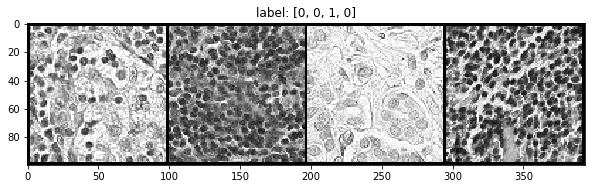

In [24]:
grid_size=4
rnd_inds=np.random.randint(0,len(val_ds),grid_size)
print("image indices:",rnd_inds)
x_grid_val=[val_ds[i][0] for i in range(grid_size)]
y_grid_val=[val_ds[i][1] for i in range(grid_size)]
x_grid_val=utils.make_grid(x_grid_val, nrow=4, padding=2)
print(x_grid_val.shape)
show(x_grid_val,y_grid_val)


# Transforming the data
**we will define a few image transformations and then update the dataset
transformation function**

In [25]:
train_transformer = transforms.Compose([
 transforms.RandomHorizontalFlip(p=0.5),
 transforms.RandomVerticalFlip(p=0.5),
 transforms.RandomRotation(45),
transforms.RandomResizedCrop(96,scale=(0.8,1.0),ratio=(1.0,1.0)),
 transforms.ToTensor()])

**For the validation dataset, we don't need any augmentation. So, we only convert
the images into tensors in the transforms function:**

In [26]:
val_transformer = transforms.Compose([transforms.ToTensor()])

In [27]:
# overwrite the transform functions
train_ds.transform=train_transformer
val_ds.transform=val_transformer

# Creating dataloaders

In [28]:
#let's define two dataloaders for the datasets:
from torch.utils.data import DataLoader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)

In [29]:
# extract a batch from training data
for x,y in train_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 3, 96, 96])
torch.Size([32])


In [30]:
# get a data batch from the validation dataloader
for x,y in val_dl:
    print(x.shape)
    print(y.shape)
    break


torch.Size([64, 3, 96, 96])
torch.Size([64])


# Building the classification model

In [31]:
# get labels for validation dataset
y_val=[y for _,y in val_ds]

In [32]:
#define a function to calculate the classification accuracy

def accuracy(labels, out):
    return np.sum(out==labels)/float(len(labels))

#calculate a dumb baseline for all-zero predictions:
acc_all_zeros = accuracy(y_val,np.zeros_like(y_val))
print("accuracy all zero prediction: %.2f" %acc_all_zeros)


accuracy all zero prediction: 0.59


In [33]:
acc_all_one = accuracy(y_val,np.ones_like(y_val))
print("accuracy all ones prediction: %.2f" %acc_all_one)

accuracy all ones prediction: 0.41


**let's calculate a dumb baseline for random predictions:**


In [34]:
acc_random=accuracy(y_val,np.random.randint(2,size=len(y_val)))
print("accuracy random prediction: %.2f" %acc_random)

accuracy random prediction: 0.50


**we developed findConv2DOutShape to automatically compute the output size of
a CNN and pooling layer. The inputs to this function are:**
* H_in: an integer representing the height of input data
* W_in: an integer representing the width of input data
* conv: an object of the CNN layer
* pool: an integer representing the pooling size and default to 2

The function receives the input size, H_in, W_in, and conv layer and provides the output
size, H_out, W_out. The formula to compute the output size is given in the following link:
https://pytorch.org/docs/stable/nn.html


In [35]:
import torch.nn as nn
#define the helper function

def findConv2dOutShape(H_in,W_in,conv,pool =2):
    kernel_size=conv.kernel_size
    stride=conv.stride
    padding=conv.padding
    dilation=conv.dilation
    
    # Ref: https://pytorch.org/docs/stable/nn.html
    H_out=np.floor((H_in+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
    W_out=np.floor((W_in+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)
    
    if pool:
        H_out/=pool
        W_out/=pool
        
    return int(H_out),int(W_out)

    

In [36]:
# example
conv1 = nn.Conv2d(3, 8, kernel_size=3)
h,w=findConv2dOutShape(96,96,conv1)
print(h,w)

47 47


### now let's implement the CNN model.


In [37]:
import torch.nn.functional as F
import torch.nn as nn
class Net (nn.Module):
    def __init__(self,params):
        super(Net,self). __init__()
        C_in,H_in,W_in=params["input_shape"]
        init_f=params["initial_filters"]
        num_fc1=params["num_fc1"]
        num_classes=params["num_classes"]
        self.dropout_rate=params["dropout_rate"]
        
        
        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)
        h,w=findConv2dOutShape(H_in,W_in,self.conv1)
        
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv2)
        
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv3)
        
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
        h,w=findConv2dOutShape(h,w,self.conv4)
        
        # compute the flatten size
        self.num_flatten=h*w*8*init_f
        self.fc1 = nn.Linear(self.num_flatten, num_fc1)
        self.fc2 = nn.Linear(num_fc1, num_classes)
        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, self.num_flatten)
        x = F.relu(self.fc1(x))
        x=F.dropout(x, self.dropout_rate, training= self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


# dict to define model parameters
params_model={"input_shape": (3,96,96),"initial_filters": 8,"num_fc1": 100
              ,"dropout_rate": 0.25, "num_classes": 2}
        
# create model
cnn_model = Net(params_model)
       

In [38]:
torch.cuda.is_available() 

True

In [39]:
# move model to cuda/gpu device
if torch.cuda.is_available():
    device = torch.device("cuda")
    cnn_model=cnn_model.to(device)

In [40]:
print(cnn_model.parameters)

<bound method Module.parameters of Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)>


In [41]:
print(next(cnn_model.parameters()).device)


cuda:0


In [42]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [43]:
from torchsummary import summary
summary(cnn_model, input_size=(3, 96, 96),device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 94, 94]             224
            Conv2d-2           [-1, 16, 45, 45]           1,168
            Conv2d-3           [-1, 32, 20, 20]           4,640
            Conv2d-4             [-1, 64, 8, 8]          18,496
            Linear-5                  [-1, 100]         102,500
            Linear-6                    [-1, 2]             202
Total params: 127,230
Trainable params: 127,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.92
Params size (MB): 0.49
Estimated Total Size (MB): 1.51
----------------------------------------------------------------


# Defining the loss function

In [44]:
loss_func = nn.NLLLoss(reduction="sum")

In [45]:
# use the loss in an example:

# fixed random seed
torch.manual_seed(0)

n,c=8,2
y = torch.randn(n, c, requires_grad=True)
ls_F = nn.LogSoftmax(dim=1)
y_out=ls_F(y)
print(y_out.shape)

target = torch.randint(c,size=(n,))
print(target.shape)

loss = loss_func(y_out, target)
print(loss.item())

torch.Size([8, 2])
torch.Size([8])
5.266995429992676


In [46]:
loss.backward()
print (y.data)

tensor([[-1.1258, -1.1524],
        [-0.2506, -0.4339],
        [ 0.8487,  0.6920],
        [-0.3160, -2.1152],
        [ 0.3223, -1.2633],
        [ 0.3500,  0.3081],
        [ 0.1198,  1.2377],
        [ 1.1168, -0.2473]])


# Defining the optimizer


In [47]:
cnn_model.parameters()

<generator object Module.parameters at 0x7f88ea401950>

In [48]:
# let's define an object of the Adam optimizer with a learning rate of 3e-4:

from torch import optim
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)


In [49]:
# We can read the current value of the learning rate using the following function:
def get_lr(opt):
    for param_group in opt.param_groups:
        return param_group['lr']

current_lr=get_lr(opt)
print('current lr={}'.format(current_lr))

current lr=0.0003


In [50]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# define learning rate scheduler
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

In [51]:
for i in range(100):
    lr_scheduler.step(1)

Epoch    22: reducing learning rate of group 0 to 1.5000e-04.
Epoch    43: reducing learning rate of group 0 to 7.5000e-05.
Epoch    64: reducing learning rate of group 0 to 3.7500e-05.
Epoch    85: reducing learning rate of group 0 to 1.8750e-05.


# Training and Evaluation
**first, let's develop a helper function to count the number of correct predictions
per data batch:**

In [52]:
def metrics_batch(output, target):
    # get output class
    pred = output.argmax(dim=1, keepdim=True)
    
    # compare output class with target class
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

In [53]:
def loss_batch(loss_func, output, target, opt=None):
    
    # get loss 
    loss = loss_func(output, target)
    
    # get performance metric
    metric_b = metrics_batch(output,target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b


In [54]:
# define device as a global variable
device = torch.device("cuda")

def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        
        # get model output
        output=model(xb)
        
        # get loss per batch
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        
        # update running loss
        running_loss+=loss_b
        
        # update running metric
        if metric_b is not None:
            running_metric+=metric_b

        # break the loop in case of sanity check
        if sanity_check is True:
            break
    
    # average loss value
    loss=running_loss/float(len_data)
    
    # average metric value
    metric=running_metric/float(len_data)
    
    return loss, metric

In [55]:
def train_val(model, params):
    # extract model parameters
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]
    
    # history of loss values in each epoch
    loss_history={
        "train": [],
        "val": [],
    }
    
    # histroy of metric values in each epoch
    metric_history={
        "train": [],
        "val": [],
    }
    
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # initialize best loss to a large value
    best_loss=float('inf')
    
    # main loop
    for epoch in range(num_epochs):
        
        # get current learning rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))
        
        # train model on training dataset
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate model on validation dataset    
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)
        
       
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        
        # learning rate schedule
        lr_scheduler.step(val_loss)
        if current_lr != get_lr(opt):
            print("Loading best model weights!")
            model.load_state_dict(best_model_wts) 

        print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f" %(train_loss,val_loss,100*val_metric))
        print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [56]:
import copy

loss_func = nn.NLLLoss(reduction="sum")
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

params_train={
 "num_epochs": 100,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": True,
 "lr_scheduler": lr_scheduler,
 "path2weights": "weights.pt",
}

# train and validate the model
cnn_model,loss_hist,metric_hist=train_val(cnn_model,params_train)

Epoch 0/99, current lr=0.0003
Copied best model weights!
train loss: 0.000126, dev loss: 0.000997, accuracy: 0.09
----------
Epoch 1/99, current lr=0.0003
train loss: 0.000127, dev loss: 0.000998, accuracy: 0.09
----------
Epoch 2/99, current lr=0.0003
train loss: 0.000125, dev loss: 0.000999, accuracy: 0.09
----------
Epoch 3/99, current lr=0.0003
train loss: 0.000124, dev loss: 0.000998, accuracy: 0.09
----------
Epoch 4/99, current lr=0.0003
Copied best model weights!
train loss: 0.000124, dev loss: 0.000996, accuracy: 0.09
----------
Epoch 5/99, current lr=0.0003
Copied best model weights!
train loss: 0.000127, dev loss: 0.000996, accuracy: 0.09
----------
Epoch 6/99, current lr=0.0003
Copied best model weights!
train loss: 0.000124, dev loss: 0.000995, accuracy: 0.09
----------
Epoch 7/99, current lr=0.0003
Copied best model weights!
train loss: 0.000124, dev loss: 0.000993, accuracy: 0.09
----------
Epoch 8/99, current lr=0.0003
Copied best model weights!
train loss: 0.000125, de

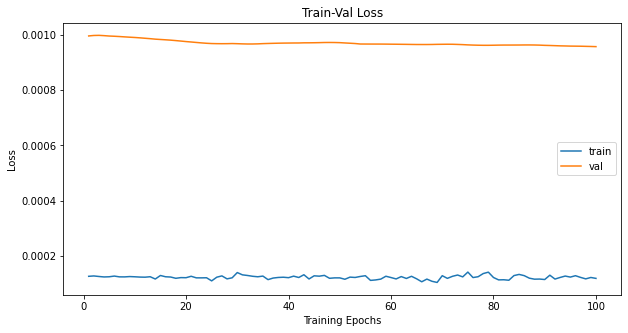

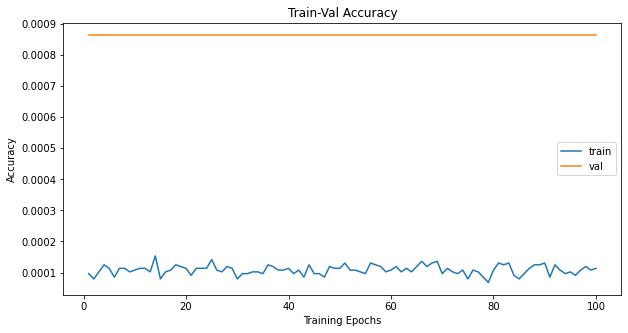

In [57]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [58]:
import copy

loss_func = nn.NLLLoss(reduction="sum")
opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

params_train={
 "num_epochs": 2,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": "weights.pt",
}

# train and validate the model
cnn_model,loss_hist,metric_hist=train_val(cnn_model,params_train)

Epoch 0/1, current lr=0.0003
Copied best model weights!
train loss: 0.430581, dev loss: 0.376257, accuracy: 83.38
----------
Epoch 1/1, current lr=0.0003
Copied best model weights!
train loss: 0.362541, dev loss: 0.352919, accuracy: 84.83
----------


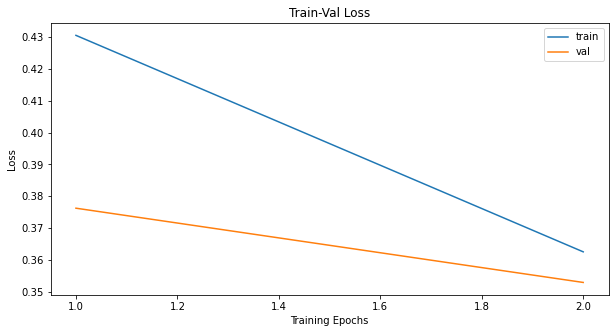

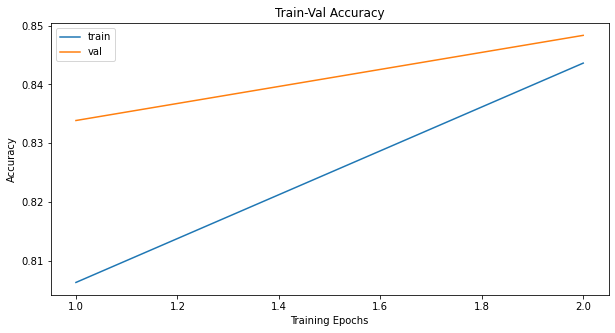

In [59]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [60]:
# # Turn off gradients
#cnn_model.eval()
#
#preds = []
#for batch_i, (data, target) in enumerate(valid_loader):
#    data, target = data.cuda(), target.cuda()
#    output = cnn_model(data)
#    if(batch_i==0):
#        print(data.shape, target.shape)
#    pr = output.detach().cpu().numpy()
#    for i in pr:
#        preds.append(i)
#
## # Create Submission file        
#sample_sub['label'] = preds 